# Presentation

In [1]:
using SARProcessing, Images, Statistics, SciPy, Plots, Dates

In [2]:
## small cheat function to easy load the test data 
const folder = "../test/testData/largeFiles/EO_workshop/"

function load_test_slc_image(folder, image_number)
    tiffs = ["S1A_IW_SLC__1SDV_20190622T015048.tiff","S1B_IW_SLC__1SDV_20190628T014958.tiff",
     "S1A_IW_SLC__1SDV_20190704T015049.tiff", "S1B_IW_SLC__1SDV_20190710T014959.tiff" ]
    annotation_files = ["s1a-iw2-slc-vv-20190622t015048-20190622t015113-027786-0322f1-005.xml",
    "s1b-iw2-slc-vv-20190628t014958-20190628t015023-016890-01fc87-005.xml",
     "s1a-iw2-slc-vv-20190704t015049-20190704t015114-027961-03283a-005.xml",
     "s1b-iw2-slc-vv-20190710t014959-20190710t015024-017065-0201b8-005.xml"]

    tiff_file = tiffs[image_number]
    is_S1A = split(tiff_file,"_")[1] == "S1A"

    window = is_S1A ? [[100 , 1500],[7600 , 20000]] : [[4*1506 , 4*1506+1600],[7500 , 20100]]

    metadata = SARProcessing.Sentinel1MetaData(joinpath(folder, annotation_files[image_number]))
    index_start = (window[1][1],window[2][1])
    data = SARProcessing.load_tiff(joinpath(folder, tiff_file))

    return SARProcessing.Sentinel1SLC(metadata,index_start,data,false)
end

load_test_slc_image (generic function with 1 method)

### Load and visualize a SAR image

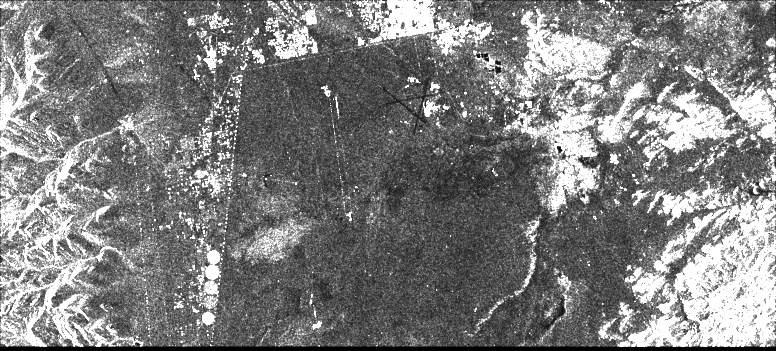

In [3]:
sar_image = load_test_slc_image(folder,1);
SARProcessing.sar2gray(sar_image.data[:,1:4:end])

### Load orbit file and create interpolator

In [4]:
orbit_sate_file_path = joinpath(folder,"/Users/lupemba/Documents/git repos/SARProcessing.jl/test/testData/largeFiles/EO_workshop/S1A_OPER_AUX_POEORB_OPOD_20210330T183728_V20190621T225942_20190623T005942.EOF");
orbit_states =  SARProcessing.load_precise_orbit_sentinel1(orbit_sate_file_path);

orbit_states[1].time, orbit_states[1].position,orbit_states[1].velocity 

(DateTime("2019-06-21T22:59:42"), [-1.962909282656e6, 4.300927106914e6, 5.255246445313e6], [-499.857794, 5774.883891, -4900.74554])

Create an orbit interpolator using the package

In [5]:
orbit_interpolator = SARProcessing.orbit_state_interpolator(orbit_states,sar_image.metadata);


Plot the interpolate z velocity vs. the one from the orbit states to show the interpolation

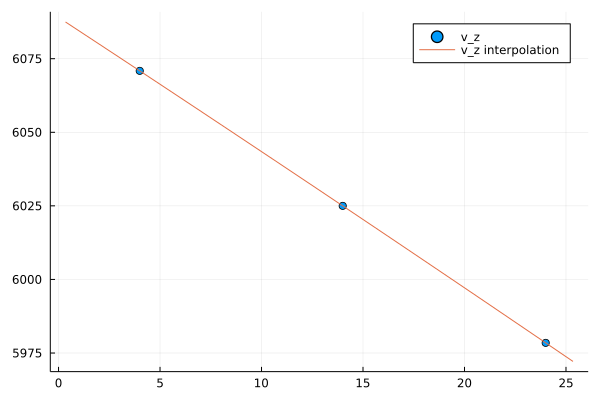

In [10]:

vz_states = [ element.velocity[3] for element in orbit_states]
t_s_states = [ Dates.value.(element.time-sar_image.metadata.reference_time) / 1000 for element in orbit_states] 

image_start = sar_image.metadata.header.start_time
image_stop = sar_image.metadata.header.stop_time

in_image = ((sar_image.metadata.header.start_time -1) .< t_s_states) .& (t_s_states  .< (sar_image.metadata.header.stop_time +1))

t_interpolation = collect(image_start:0.2:image_stop)
vz_interpolation = [orbit_interpolator(t).velocity[3] for t in t_interpolation]

p=scatter(t_s_states[in_image],vz_states[in_image], label="v_z")
plot!(t_interpolation , vz_interpolation, label="v_z interpolation")


## Geolocate the air strip in the picture

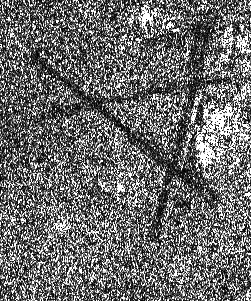

In [11]:
SARProcessing.sar2gray(sar_image.data[300:600,6000:4:7000])

Find the coordinate of the airstrip

In [12]:
index_of_air_strip = (450 + sar_image.index_start[1][1] -1, 6500+ sar_image.index_start[2][1] -1)
height_air_strip = 10 ## just a guess

coordinates_air_strip = SARProcessing.sar_index2geodetic(index_of_air_strip... ,
    height_air_strip,orbit_interpolator,sar_image.metadata)

coordinates_air_strip[1:2] .*180/pi

2-element Vector{Float64}:
   35.68832440994117
 -117.70472737718411

Check the coordinate with google map

https://www.google.com/maps/@35.6883244,-117.7047274,3058m/data=!3m1!1e3

There is also a function to go from index to coordinate

In [13]:
index_air_strip_computed = SARProcessing.geodetic2SAR_index(coordinates_air_strip,orbit_interpolator,sar_image.metadata) 

index_air_strip_computed[1]  - sar_image.index_start[1][1] +1, index_air_strip_computed[2]  - sar_image.index_start[2][1] +1

(449.99959911223004, 6499.999999999833)

SARProcessing.geodetic2SAR_index(coords, interpolator_a, metadataA)...] 
    for coords in dem_geodetic_coordinates